In [1]:
import tensorflow as tf
import numpy as np
import  matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pandas as pd
import time
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings("ignore")

In [3]:
# In[] 
def get_angles(pos, i, d_model):
    # 这里的i等价与公式中的2i和2i+1
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(maximum_position_encoding, d_model):
    
    angle_rads = get_angles(np.arange(maximum_position_encoding)[:, np.newaxis], np.arange(d_model)[np.newaxis, :],d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :,0]  # (batch_size, 1, 1, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
      output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)   ## 64
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits = scaled_attention_logits + (mask * -1e9)  
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    assert d_model % self.num_heads == 0# d_model self.num_heads 要能够整除
    self.depth = d_model // self.num_heads
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    self.dense = tf.keras.layers.Dense(d_model)
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)                  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()
    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
  def call(self, x, training, mask):
    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    return out2

class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding = tf.keras.layers.Dense(d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
    self.enc_layers = [ EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers) ]
    self.dropout = tf.keras.layers.Dropout(rate)
  def call(self, x, training, mask):
    seq_len = tf.shape(x)[1]
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    # print('------------------\n',seq_len)
#    x=tf.tile(tf.expand_dims(x,2),self.d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    # print(x.shape)
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)
    # print(x.shape)
    # print(mask.shape)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    return x  # (batch_size, input_seq_len, d_model)

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 input_vocab_size, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    def call(self, inp, training, enc_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        final_output = self.final_layer(enc_output)  # (batch_size, inp_seq_len, target_vocab_size)
        return final_output[:,-1,:]
def train_step(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    # enc_padding_mask = None
    with tf.GradientTape() as tape:
        predictions = transformer(inp, True, enc_padding_mask)
        loss = loss_function(tar, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)

In [4]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [6]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [7]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [8]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in *  n_features
train_data, train_label = train[:, :n_obs], train[:, n_obs:]
test_data, test_label = test[:, :n_obs], test[:, n_obs:]

# 将数据转换为3D输入，[samples, timesteps, features]
train_data = train_data.reshape((train_data.shape[0], n_in, n_features))
test_data = test_data.reshape((test_data.shape[0], n_in, n_features))
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(1149, 3, 1) (1149, 1) (288, 3, 1) (288, 1)


In [9]:
# In[]
EPOCHS  = 100  #训练次数
BATCH_SIZE = 256      ## batchsize
VAL_BATCH_SIZE=64      # valid batchsize
num_layers = 1         ## encoder 层数
d_model = 16          # dmodel要是num_heads的整数倍
dff = 100              # 编码层中前向网络的节点数
num_heads = 4   #多头注意力的头数量
dropout_rate = 0.5  #dropout
input_en_vocab_size  = train_data.shape[-1] #输入节点数
target_sp_vocab_size = train_label.shape[-1] #输出节点数

In [10]:
optimizer = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_function = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')

In [11]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_en_vocab_size, target_sp_vocab_size, 
                          maximum_position_encoding=5000, 
                          rate=dropout_rate)


checkpoint_path = "./checkpoints/"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

1 train time:0.14 s,valid time:0.05 s,train loss:1.17535, valid loss:0.48454.
2 train time:0.08 s,valid time:0.03 s,train loss:0.41681, valid loss:0.10016.
3 train time:0.08 s,valid time:0.03 s,train loss:0.34193, valid loss:0.06666.
4 train time:0.08 s,valid time:0.03 s,train loss:0.25092, valid loss:0.21540.
5 train time:0.08 s,valid time:0.03 s,train loss:0.20910, valid loss:0.24250.
6 train time:0.08 s,valid time:0.03 s,train loss:0.20855, valid loss:0.09441.
7 train time:0.08 s,valid time:0.03 s,train loss:0.19094, valid loss:0.08060.
8 train time:0.08 s,valid time:0.03 s,train loss:0.17433, valid loss:0.11747.
9 train time:0.08 s,valid time:0.03 s,train loss:0.16282, valid loss:0.14503.
10 train time:0.08 s,valid time:0.03 s,train loss:0.15615, valid loss:0.12869.
11 train time:0.08 s,valid time:0.03 s,train loss:0.15446, valid loss:0.11678.
12 train time:0.08 s,valid time:0.03 s,train loss:0.13932, valid loss:0.09912.
13 train time:0.08 s,valid time:0.03 s,train loss:0.13404, va

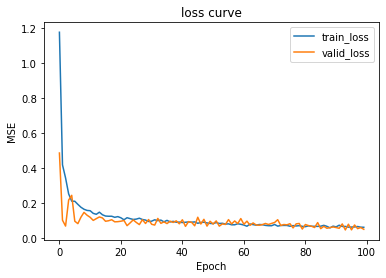

In [12]:
# In[] 训练
train_again=True #为 False 的时候就直接加载训练好的模型进行测试
if train_again: 
    num_samples,num_valid_samples = train_data.shape[0],test_data.shape[0]
    num_batches,num_valid_batches = int(num_samples/BATCH_SIZE),int(num_valid_samples/VAL_BATCH_SIZE)
    trainloss,validloss=[],[]

    for epoch_n in range(EPOCHS):
        start_time = time.time()
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        cost,cost2=0,0
        for batch_n in range(num_batches):
            rand_index = indices[BATCH_SIZE*batch_n:BATCH_SIZE*(batch_n+1)]
            inp = train_data[rand_index]
            tar = train_label[rand_index]
            
            train_loss.reset_states()
            
            inp_tf = tf.convert_to_tensor(inp, dtype=tf.float32)
            tar_tf = tf.convert_to_tensor(tar, dtype=tf.float32)        
            train_step(inp_tf, tar_tf)
            cost += train_loss.result().numpy()/num_batches
        end1_time=time.time()
        # # compute validationset loss
        for batch_n in range(num_valid_batches):
            inp = test_data[batch_n*VAL_BATCH_SIZE:(batch_n+1)*VAL_BATCH_SIZE]
            tar = test_label[batch_n*VAL_BATCH_SIZE:(batch_n+1)*VAL_BATCH_SIZE]
            valid_loss.reset_states()
            inp_tf = tf.convert_to_tensor(inp, dtype=tf.float32)
            tar_tf = tf.convert_to_tensor(tar, dtype=tf.float32)
            enc_padding_mask= create_padding_mask(inp_tf)
            predictions = transformer(inp_tf, False, enc_padding_mask)
            loss = loss_function(tar_tf, predictions)
            valid_loss(loss)
            cost2 += valid_loss.result().numpy() / num_valid_batches

        end2_time = time.time()
        if (epoch_n + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
        print(epoch_n + 1,'train time:%.2f s,valid time:%.2f s,train loss:%.5f, valid loss:%.5f.'%(end1_time-start_time,end2_time-end1_time,cost,cost2))
        trainloss.append(cost)
        validloss.append(cost2)

    plt.figure
    plt.plot(trainloss,label='train_loss')
    plt.plot(validloss,label='valid_loss')
    plt.legend()
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.title('loss curve')
#     plt.savefig('model/transformer loss curve.jpg')
   
else:
    # 加载最后一个模型
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print ('Latest checkpoint restored!!')
    else:
        ckpt.restore('checkpoints/ckpt-20')

In [13]:
#  预测
pred=np.zeros((0,test_label.shape[1]))
batchsize=64#
n_samples=test_data.shape[0]
n_baches=np.ceil(n_samples/batchsize)
for i in range(int(n_baches)):
    start = i*batchsize
    end = min( (i+1)*batchsize,n_samples)
    inp_tf = tf.convert_to_tensor(test_data[start:end,:,:], dtype=tf.float32)
    enc_padding_mask = create_padding_mask(inp_tf)
    predictions = transformer(inp_tf, False, enc_padding_mask)
    pred=np.vstack([pred,predictions.numpy()])
inv_yhat = scaler.inverse_transform(pred)
inv_y = scaler.inverse_transform(test_label)

In [14]:
# 计算RMSE
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
        if abs(y_true[index])>10:
            temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
            record.append(temp_mape)
    return np.mean(record) * 100
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(inv_y, inv_yhat))
print('Test MAPE: %.7f' % mape(inv_y, inv_yhat))
print('Test R2: %.7f' % r2_score(inv_y, inv_yhat))

Test RMSE: 36.0165574
Test MAE: 28.2495542
Test MAPE: 10.6678934
Test R2: 0.9512940


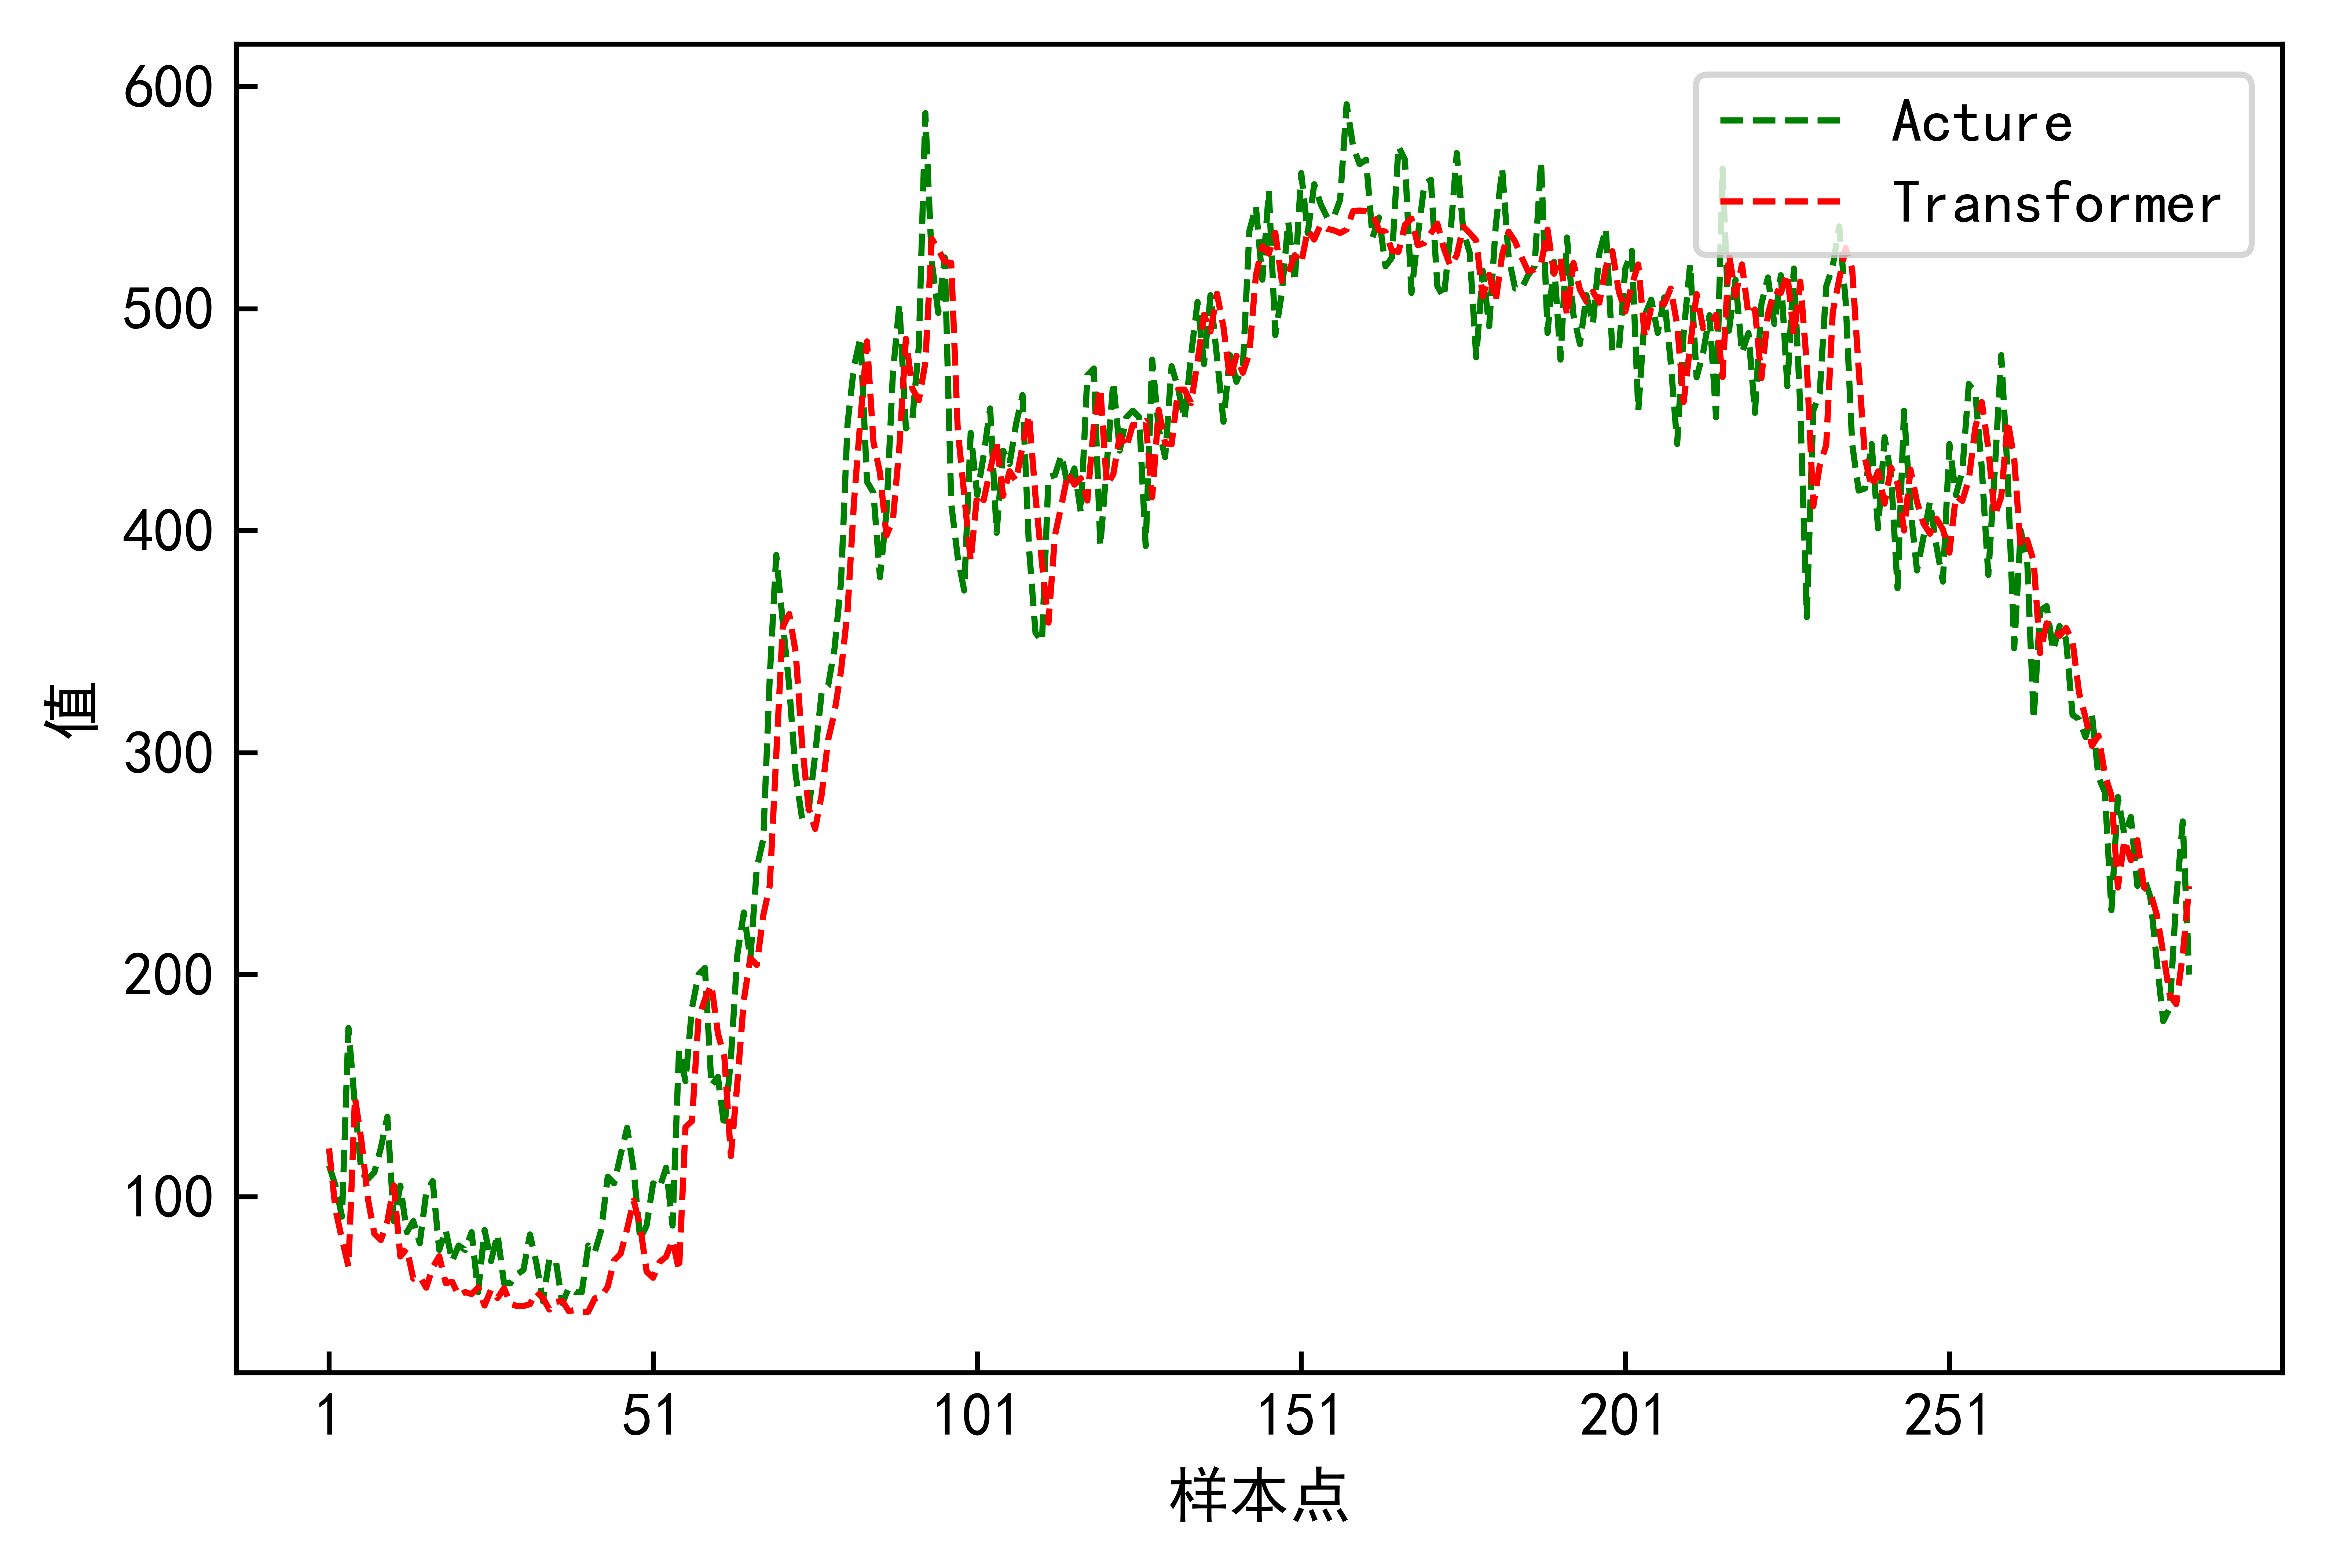

In [15]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(inv_yhat)+1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, inv_y, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, inv_yhat, color='red',linestyle="--",linewidth=1,label='Transformer')
# plt.plot(x, inv_y,color='g',linewidth=1, label='真实值')
# plt.plot(x, inv_yhat,color='red',linestyle="--",linewidth=1,label='预测值')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('figure/LSTM预测结果图.png')
plt.show()

In [16]:
#保存预测结果
savemat('结果/transformer_result.mat',{'true':inv_y,'pred':inv_yhat})